In [139]:
import pandas as pd
import pickle
import numpy as np
import xgboost
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold,StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns",50)

# Load Training Set

In [140]:
# Load the training set
df = pd.read_csv('training_data/utah_training_set.csv').drop(columns=['fid','index','join_key'],errors='ignore')
df = df.dropna(how='any',axis=0)

In [141]:
ohe_fields=['one_way','surface_type']

# One-Hot encode a couple of variables
df_ohe = pd.get_dummies(df,columns=ohe_fields)

# Get the one-hot variable names
ohe_feature_names = pd.get_dummies(df[ohe_fields],columns=ohe_fields).columns.tolist()
df_ohe

,timestamp,segment_id,station_id,hour,weekday,month,pre_dir,street_type,suf_dir,speed_limit,surface_width,aadt,sinuosity,euclidean_length,segment_length,near_major_road,road_orient_approx,at_intersection,near_billboard,accident_counts,target,wind_speed,visibility,temperature,precip_depth,snow_depth,snowing,raining,foggy,icy,hailing,thunderstorm,solar_azimuth,solar_elevation,one_way_0,one_way_1,one_way_2,surface_type_,surface_type_100,surface_type_200,surface_type_300,surface_type_DIRT,surface_type_IMPROVED,surface_type_OTHER,surface_type_PAVED
0,2010-01-01 09:00:00+00:00,21821,72470093141,2,4,1,S,ST,,40.0,0,2582.0,1.000000,183.940054,183.940054,0,1.548009,1,0,2.0,1,0.000000,16093.0,-7.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.133310,-64.221430,1,0,0,0,0,0,0,0,0,0,1
1,2010-01-01 18:00:00+00:00,32221,72470093141,11,4,1,S,,,65.0,50,2608.0,1.001568,470.656666,471.394576,0,1.728398,0,0,11.0,1,0.000000,16093.0,-5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,157.114449,22.926000,1,0,0,0,0,0,0,0,0,0,1
2,2010-01-02 09:00:00+00:00,42886,72470093141,2,5,1,E,,,65.0,50,6644.0,1.028415,3445.573327,3543.478498,0,3.010128,1,0,29.0,1,0.000000,16093.0,-13.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.812066,-64.224402,1,0,0,0,0,0,0,0,0,0,1
3,2010-01-03 01:00:00+00:00,28854,72470093141,18,5,1,W,,,65.0,0,7849.0,1.004078,1949.083740,1957.032150,0,0.431349,1,0,29.0,1,2.100000,16093.0,-11.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,247.537151,-8.984745,1,0,0,0,0,0,0,0,0,0,1
4,2010-01-03 15:00:00+00:00,11320,72470093141,8,6,1,E,,,65.0,0,6215.0,1.076797,1983.762463,2136.108683,0,2.192179,1,0,31.0,1,0.000000,16093.0,-8.900000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121.156632,0.908545,1,0,0,1,0,0,0,0,0,0,0
5,2010-01-03 23:00:00+00:00,33429,72470093141,16,6,1,W,ST,,25.0,40,8443.0,1.000000,207.097648,207.097648,0,0.016132,1,0,22.0,1,0.000000,16093.0,-5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,227.536015,10.486503,1,0,0,0,0,0,0,0,0,0,1
6,2010-01-05 02:00:00+00:00,28206,72470093141,19,0,1,S,,,40.0,50,10981.0,1.000231,290.952318,291.019565,0,1.110549,1,0,5.0,1,2.100000,16093.0,-9.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,256.499403,-19.498070,1,0,0,0,0,0,0,0,0,0,1
7,2010-01-05 22:00:00+00:00,28854,72470093141,15,1,1,W,,,65.0,0,7849.0,1.004078,1949.083740,1957.032150,0,0.431349,1,0,29.0,1,0.000000,16093.0,-4.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215.491370,18.282809,1,0,0,0,0,0,0,0,0,0,1
8,2010-01-06 15:00:00+00:00,9235,72470093141,8,2,1,W,,,40.0,40,1468.0,1.000000,434.355104,434.355104,0,0.215251,1,0,2.0,1,1.500000,16093.0,-6.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.694062,0.935764,1,0,0,0,0,0,0,0,0,0,1
9,2010-01-07 12:00:00+00:00,42886,72470093141,5,3,1,E,,,65.0,50,6644.0,1.028415,3445.573327,3543.478498,0,3.010128,1,0,29.0,1,1.500000,16093.0,-8.900000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.128956,-31.796594,1,0,0,0,0,0,0,0,0,0,1


# Continuous Features
These are currently:
* Historical Accident Count
* Speed Limit (if available)
* Sinuosity (Road curavture metric)
* AADT (Annual Average Daily Traffic, if available)
* Road Surface Width (If available)
* Precipitation Depth
* Snow Depth
* Temperature
* Visibility
* Wind Speed
* Road Orientation

These will be rescaled by scikit-learn's standard rescaler

In [142]:
# Sinuosity is typically close to 1, even for moderately curvy roads. A high sinuosity means a longer road.
feature_transforms = {
    'sinuosity': np.log
}
for feature,transform in feature_transforms.items():
    df_ohe[feature] = transform(df_ohe[feature])

# Continuously valued features
float_feature_names = [
    'accident_counts',
    'speed_limit',
    'aadt',
    'surface_width',
    'sinuosity',
    'euclidean_length',
    'segment_length',
    'road_orient_approx',
    'precip_depth',
    'snow_depth',
    'temperature',
    'visibility',
    'wind_speed'
]
float_features = df_ohe.xs(float_feature_names,axis=1).values

# Use scikit-learn's StandardScaler
scaler = StandardScaler()
float_scaled = scaler.fit_transform(float_features)

df_ohe[float_feature_names] = float_scaled

with open('scalers.pkl','wb') as fp:
    pickle.dump(scaler,fp)


In [143]:
y = df['target'].values

binary_feature_names = [
    'snowing',
    'raining',
    'icy',
    'thunderstorm',
    'hailing',
    'foggy',
    'near_billboard',
    'at_intersection',
]
temporal_feature_names = [
    'hour',
    'month',
    'weekday'
]

df_ohe = df_ohe.xs(float_feature_names+binary_feature_names+ohe_feature_names+temporal_feature_names,axis=1)

In [144]:
X = df_ohe.values
y = df['target'].values
feature_names = df_ohe.columns.tolist()

In [145]:
wrangler = {
    'scaler': scaler,
    'float_feature_names': float_feature_names,
    'drop_columns': drop_columns,
    'ohe_fields': ohe_fields,
    'feature_names': feature_names,
    'feature_transforms': feature_transforms 
}
with open('wrangler.pkl','wb') as fp:
    pickle.dump(wrangler,fp)

# Define Model (Gradient Boosting)

We use XGBoost to build the gradient boosting model

In [146]:
feature_sel = range(len(feature_names))
Xs = X[:,feature_sel]
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.1)#, random_state=2)
fnames = np.array(feature_names)[feature_sel]

X_train = xgboost.DMatrix(X_train,label=y_train,feature_names=fnames)
X_test =  xgboost.DMatrix(X_test,label=y_test,feature_names=fnames)


params = {
    'n_estimators': 200,
    'max_depth':10,
    'min_child_weight': 1.0,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'objective':'binary:logistic',
}
booster = xgboost.train(params,X_train)


In [147]:
print(fnames)

['accident_counts' 'speed_limit' 'aadt' 'surface_width' 'sinuosity'
 'euclidean_length' 'segment_length' 'road_orient_approx' 'precip_depth'
 'snow_depth' 'temperature' 'visibility' 'wind_speed' 'snowing' 'raining'
 'icy' 'thunderstorm' 'hailing' 'foggy' 'near_billboard' 'at_intersection'
 'one_way_0' 'one_way_1' 'one_way_2' 'surface_type_ ' 'surface_type_100'
 'surface_type_200' 'surface_type_300' 'surface_type_DIRT'
 'surface_type_IMPROVED' 'surface_type_OTHER' 'surface_type_PAVED' 'hour'
 'month' 'weekday']


# Which features are most important?

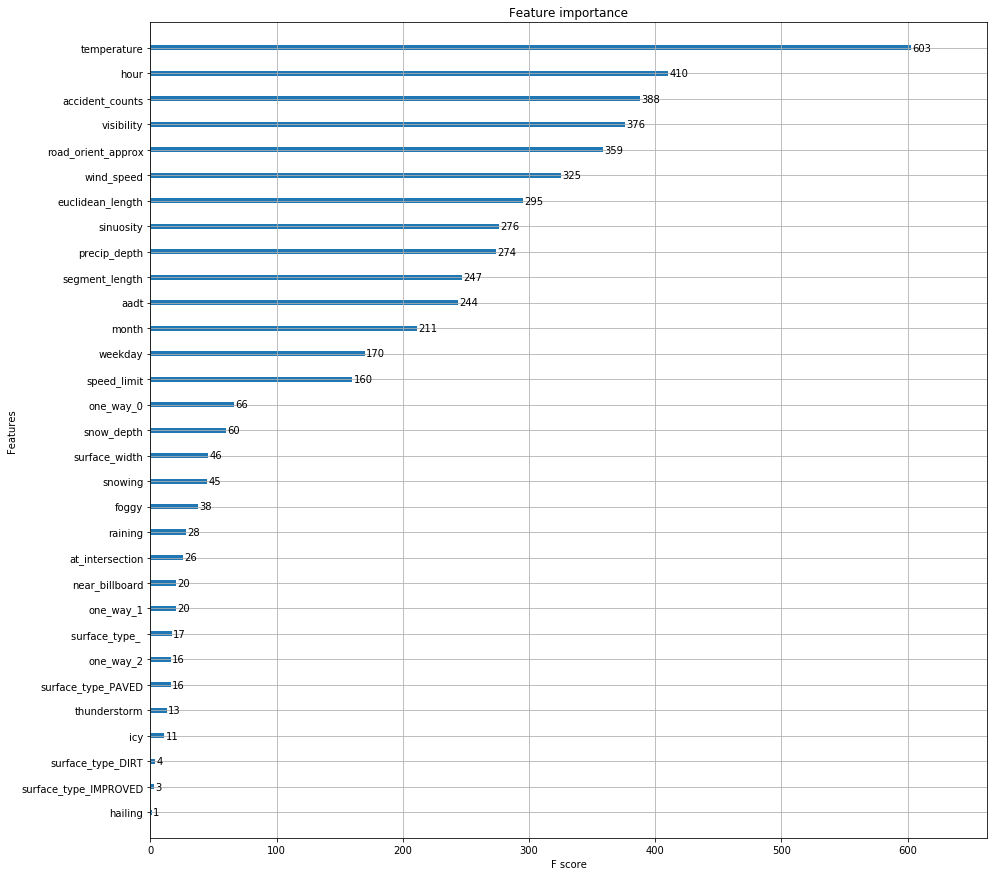

In [148]:
plt.figure(figsize=(15,15))
xgboost.plot_importance(booster,ax=plt.gca(),importance_type='weight')

In [149]:
booster.save_model('0002.model')

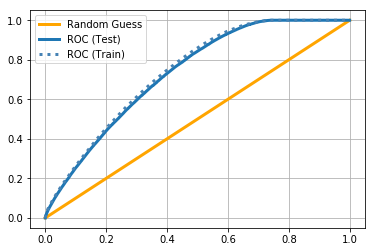

In [150]:
y_pred_test = booster.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_test)

y_pred_train = booster.predict(X_train)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange',lw=3)
plt.plot(fpr,tpr,label='ROC (Test)',lw=3)
plt.plot(fpr_train,tpr_train,'r:',label='ROC (Train)',color='steelblue',lw=3)
plt.grid()
plt.legend()

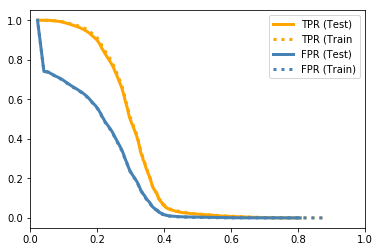

In [151]:

plt.plot(thresholds,tpr,'r-',label='TPR (Test)',color='orange',lw=3)
plt.plot(thresholds_train,tpr_train,'r:',label='TPR (Train',color='orange',lw=3)
plt.plot(thresholds,fpr,'r-',label='FPR (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,fpr_train,'r:',label='FPR (Train)',color='steelblue',lw=3)
plt.gca().set_xbound(lower=0,upper=1)
plt.legend()

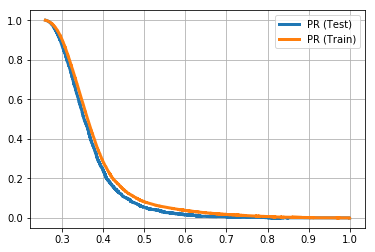

In [156]:
plt.figure(figsize=(15,15))

y_pred_test = booster.predict(X_test)
y_pred_train = booster.predict(X_train)

precision,recall,thresholds = precision_recall_curve(y_test,y_pred_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot(precision,recall,label='PR (Test)',lw=3)
plt.plot(precision_train,recall_train,label='PR (Train)',lw=3)

plt.grid()
plt.legend()

In [153]:
len(X_train.feature_names)

35

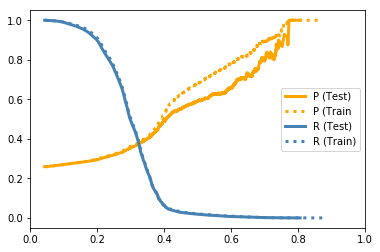

In [154]:
plt.plot(thresholds,precision[:-1],'r-',label='P (Test)',color='orange',lw=3)
plt.plot(thresholds_train,precision_train[:-1],'r:',label='P (Train',color='orange',lw=3)
plt.plot(thresholds,recall[:-1],'r-',label='R (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,recall_train[:-1],'r:',label='R (Train)',color='steelblue',lw=3)
#plt.plot([0,1],[0,1],'k-',lw=2)
plt.gca().set_xbound(lower=0,upper=1)
plt.legend()

In [155]:
y_pred_test = booster.predict(X_test) > 0.2
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test AP:',average_precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = booster.predict(X_test)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))

y_pred_train = booster.predict(X_train) > 0.2
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Test AP:',average_precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(X_train)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))

Test Accuracy: 0.5359355103821588
Test F1: 0.44421491369306204
Test Precision: 0.29495154874575397
Test AP: 0.28601826871620367
Test Recall: 0.8993308403857508
Test AUC: 0.7316215962893184
Train Accuracy: 0.5402712218285208
Train F1: 0.44866197878148334
Train Precision: 0.29756912032267063
Test AP: 0.2893935313968402
Train Recall: 0.9114647564690275
Train AUC: 0.7411196047254358
